# Flexible BAO examples

In this notebook we will explore a new broadband parameterization for BAO fits to data power spectrum and correlation function.
Look first at notebooks basic_examples.ipynb to get a flavor of *desilike* mechanisms.

## BAO likelihood
Let us define the power spectrum BAO likelihood, generating fake synthetic data.

In [1]:
import numpy as np

from desilike.theories.galaxy_clustering import BAOPowerSpectrumTemplate, FlexibleBAOWigglesTracerPowerSpectrumMultipoles, FlexibleBAOWigglesTracerCorrelationFunctionMultipoles
from desilike.observables.galaxy_clustering import TracerPowerSpectrumMultipolesObservable, TracerCorrelationFunctionMultipolesObservable
from desilike.likelihoods import ObservablesGaussianLikelihood
from desilike import setup_logging

setup_logging()

z = 1.
template = BAOPowerSpectrumTemplate(z=z, fiducial='DESI')
theory = FlexibleBAOWigglesTracerPowerSpectrumMultipoles(template=template)
params = {'b1': 2.}
# Generate synthetic monopole and quadrupole, between 0.02 and 0.35 h/Mpc
observable = TracerPowerSpectrumMultipolesObservable(data=params, covariance=None,
                                                     klim={0: [0.005, 0.35, 0.005], 2: [0.005, 0.35, 0.005]},
                                                     theory=theory)

observable.init.update(data=observable.flatdata)  # fix the data vector

from desilike.observables.galaxy_clustering import BoxFootprint, ObservablesCovarianceMatrix

footprint = BoxFootprint(volume=5e9, nbar=1e-4)  # box with volume of 5 (Gpc/h)^3 and density of 1e-4 (h/Mpc)^3
covariance = ObservablesCovarianceMatrix(observables=[observable], footprints=[footprint])
likelihood = ObservablesGaussianLikelihood(observables=[observable], covariance=covariance(**params))

/home/adematti/Bureau/DESI/NERSC/cosmodesi/cosmoprimo/cosmoprimo/eisenstein_hu.py:23: UserWarning: EisensteinHuNoWiggleEngine cannot cope with massive neutrinos
  warnings.warn('{} cannot cope with massive neutrinos'.format(self.__class__.__name__))
/home/adematti/anaconda3/envs/cosmodesi/lib/python3.9/site-packages/numpy/lib/polynomial.py:1337: FutureWarning: In the future extra properties will not be copied across when constructing one poly1d from another
  other = poly1d(other)


## Broadband
The broadband is parameterized as a sum of TSC (or PCS) kernels located at periodically separated pivot points.

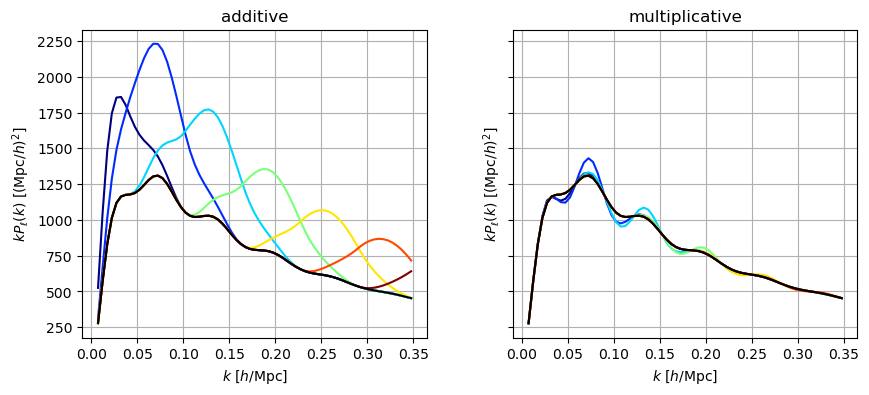

In [2]:
from matplotlib import pyplot as plt

fig, lax = plt.subplots(1, 2, sharex=False, sharey=True, figsize=(10, 4), squeeze=True)
fig.subplots_adjust(wspace=0.25)

for iax, mode in enumerate(['additive', 'multiplicative']):
    ax = lax[iax]
    names = theory.all_params.names(basename=mode[0] + 'l0*')
    cmap = plt.get_cmap('jet', len(names))
    for iname, name in enumerate(names):
        pk = theory(**{name: 1. if iax == 0 else 2.})
        for ill, ell in enumerate(theory.ells[:1]):
            ax.plot(theory.k, theory.k * pk[ill], color=cmap(iname * 1. / len(names)))
        pk = theory(**{name: 0.})
    ax.plot(theory.k, theory.k * pk[ill], color='k')
    ax.grid(True)
    ax.set_xlabel(r'$k$ [$h/\mathrm{Mpc}$]')
    ax.set_ylabel(r'$k P_{\ell}(k)$ [$(\mathrm{Mpc}/h)^{2}$]')
    ax.set_title(mode)
plt.show()

## Fit
Let us perform some likelihood (actually posterior, including parameter priors) profiling.

In [3]:
from desilike.profilers import MinuitProfiler

for param in likelihood.all_params.select(basename=['al*', 'ml*']):
    param.update(derived='.auto')
profiler = MinuitProfiler(likelihood, seed=42)
profiles = profiler.maximize(niterations=2)

[000004.89] [0/1] 05-24 06:01  MinuitProfiler            INFO     Varied parameters: ['qpar', 'qper'].
[000005.49] [0/1] 05-24 06:01  Differentiation           INFO     Varied parameters: ['al0_0', 'al0_1', 'al0_2', 'al0_3', 'al0_4', 'al0_5', 'al0_6', 'al2_0', 'al2_1', 'al2_2', 'al2_3', 'al2_4', 'al2_5', 'al2_6', 'ml0_0', 'ml0_1', 'ml0_2', 'ml0_3', 'ml0_4', 'ml0_5', 'ml0_6', 'ml2_0', 'ml2_1', 'ml2_2', 'ml2_3', 'ml2_4', 'ml2_5', 'ml2_6'].
[000005.54] [0/1] 05-24 06:01  Differentiation           INFO     Varied parameters: ['al0_0', 'al0_1', 'al0_2', 'al0_3', 'al0_4', 'al0_5', 'al0_6', 'al2_0', 'al2_1', 'al2_2', 'al2_3', 'al2_4', 'al2_5', 'al2_6', 'ml0_0', 'ml0_1', 'ml0_2', 'ml0_3', 'ml0_4', 'ml0_5', 'ml0_6', 'ml2_0', 'ml2_1', 'ml2_2', 'ml2_3', 'ml2_4', 'ml2_5', 'ml2_6'].


In [4]:
print(profiles.to_stats(tablefmt='pretty'))

+---------------------------------------+--------+---------+-------+
| chi2 / (138 - 30) = 0.00 / 108 = 0.00 | varied | bestfit | error |
+---------------------------------------+--------+---------+-------+
|                 qpar                  |  True  |  1.000  | 0.018 |
|                 qper                  |  True  |  1.000  | 0.014 |
|                 al0_0                 |  True  | -6.1e-7 |       |
|                 al0_1                 |  True  | 3.2e-7  |       |
|                 al0_2                 |  True  | -1.6e-7 |       |
|                 al0_3                 |  True  | 5.9e-8  |       |
|                 al0_4                 |  True  | 5.7e-8  |       |
|                 al0_5                 |  True  | -2.7e-7 |       |
|                 al0_6                 |  True  | 6.5e-7  |       |
|                 al2_0                 |  True  | 1.6e-8  |       |
|                 al2_1                 |  True  | -3.7e-8 |       |
|                 al2_2           

array([<AxesSubplot:ylabel='$q_{\\parallel}$'>,
       <AxesSubplot:ylabel='$q_{\\perp}$'>], dtype=object)

[000031.05] [0/1] 05-24 06:02  matplotlib.mathtext       INFO     Substituting symbol \perp from STIXGeneral
[000031.05] [0/1] 05-24 06:02  matplotlib.mathtext       INFO     Substituting symbol \perp from STIXGeneral
[000031.12] [0/1] 05-24 06:02  matplotlib.mathtext       INFO     Substituting symbol \perp from STIXGeneral
[000031.13] [0/1] 05-24 06:02  matplotlib.mathtext       INFO     Substituting symbol \perp from STIXGeneral


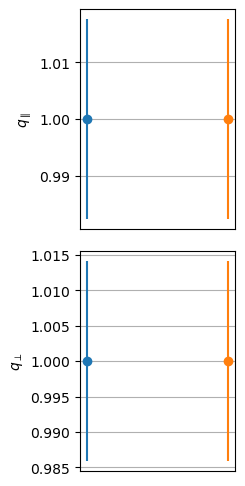

In [5]:
from desilike.samples import plotting
plotting.plot_aligned_stacked(profiles, params=['qpar', 'qper'])

[000031.22] [0/1] 05-24 06:02  Differentiation           INFO     Varied parameters: ['al0_0', 'al0_1', 'al0_2', 'al0_3', 'al0_4', 'al0_5', 'al0_6', 'al2_0', 'al2_1', 'al2_2', 'al2_3', 'al2_4', 'al2_5', 'al2_6', 'ml0_0', 'ml0_1', 'ml0_2', 'ml0_3', 'ml0_4', 'ml0_5', 'ml0_6', 'ml2_0', 'ml2_1', 'ml2_2', 'ml2_3', 'ml2_4', 'ml2_5', 'ml2_6'].
[000031.25] [0/1] 05-24 06:02  Differentiation           INFO     Varied parameters: ['al0_0', 'al0_1', 'al0_2', 'al0_3', 'al0_4', 'al0_5', 'al0_6', 'al2_0', 'al2_1', 'al2_2', 'al2_3', 'al2_4', 'al2_5', 'al2_6', 'ml0_0', 'ml0_1', 'ml0_2', 'ml0_3', 'ml0_4', 'ml0_5', 'ml0_6', 'ml2_0', 'ml2_1', 'ml2_2', 'ml2_3', 'ml2_4', 'ml2_5', 'ml2_6'].


array([<AxesSubplot:ylabel='$k \\Delta P_{0}(k)$ [$(\\mathrm{Mpc}/h)^{2}$]'>,
       <AxesSubplot:xlabel='$k$ [$h/\\mathrm{Mpc}$]', ylabel='$k \\Delta P_{2}(k)$ [$(\\mathrm{Mpc}/h)^{2}$]'>],
      dtype=object)

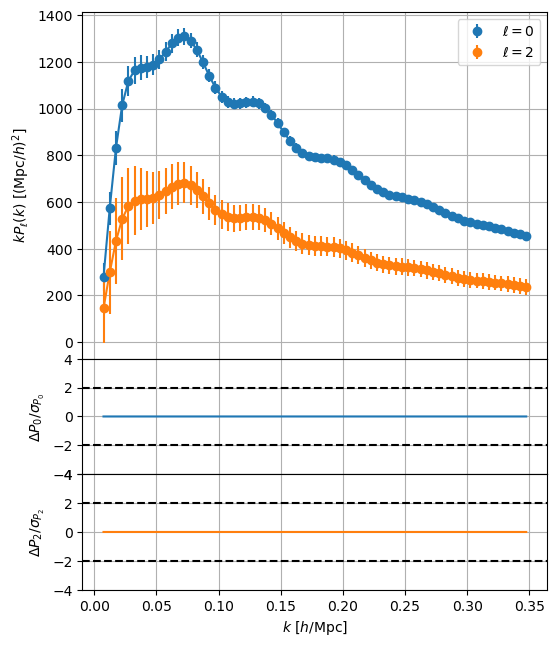

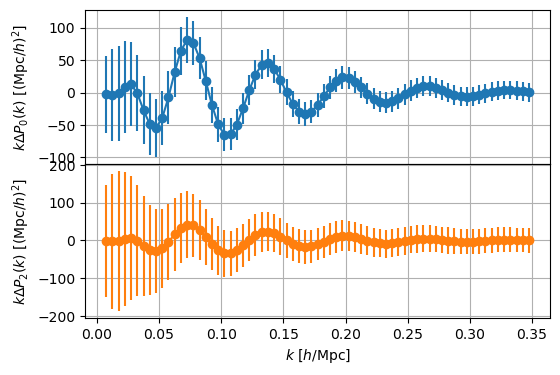

In [6]:
likelihood(**profiler.profiles.bestfit.choice(params=likelihood.varied_params))
observable.plot()
observable.plot_wiggles()

## Detection level
Let us estimate the detection level, by running profiling without and with wiggles.

In [7]:
template = BAOPowerSpectrumTemplate(z=z, fiducial='DESI', apmode='qiso', only_now=True)
theory.init.update(template=template)

for param in likelihood.all_params.select(basename='al*'):
    param.update(derived='.auto')

grid = np.linspace(0.9, 1.1, 21)
profiler = MinuitProfiler(likelihood, seed=42)
profiler.maximize(niterations=1)
profiles_nowiggle = profiler.profile(params='qiso', grid=grid)

[000035.06] [0/1] 05-24 06:02  MinuitProfiler            INFO     Varied parameters: ['qiso'].
[000035.14] [0/1] 05-24 06:02  Differentiation           INFO     Varied parameters: ['al0_0', 'al0_1', 'al0_2', 'al0_3', 'al0_4', 'al0_5', 'al0_6', 'al2_0', 'al2_1', 'al2_2', 'al2_3', 'al2_4', 'al2_5', 'al2_6'].


/home/adematti/Bureau/DESI/NERSC/cosmodesi/cosmoprimo/cosmoprimo/eisenstein_hu.py:23: UserWarning: EisensteinHuNoWiggleEngine cannot cope with massive neutrinos
  warnings.warn('{} cannot cope with massive neutrinos'.format(self.__class__.__name__))


[000035.16] [0/1] 05-24 06:02  Differentiation           INFO     Varied parameters: ['al0_0', 'al0_1', 'al0_2', 'al0_3', 'al0_4', 'al0_5', 'al0_6', 'al2_0', 'al2_1', 'al2_2', 'al2_3', 'al2_4', 'al2_5', 'al2_6'].


In [8]:
template.init.update(only_now=False)

for param in likelihood.all_params.select(basename=['al*', 'ml*']):
    param.update(derived='.auto')

profiler = MinuitProfiler(likelihood, seed=42)
profiler.maximize(niterations=1)
profiles = profiler.profile(params='qiso', grid=grid)

[000043.84] [0/1] 05-24 06:02  MinuitProfiler            INFO     Varied parameters: ['qiso'].
[000043.92] [0/1] 05-24 06:02  Differentiation           INFO     Varied parameters: ['al0_0', 'al0_1', 'al0_2', 'al0_3', 'al0_4', 'al0_5', 'al0_6', 'al2_0', 'al2_1', 'al2_2', 'al2_3', 'al2_4', 'al2_5', 'al2_6', 'ml0_0', 'ml0_1', 'ml0_2', 'ml0_3', 'ml0_4', 'ml0_5', 'ml0_6', 'ml2_0', 'ml2_1', 'ml2_2', 'ml2_3', 'ml2_4', 'ml2_5', 'ml2_6'].
[000043.95] [0/1] 05-24 06:02  Differentiation           INFO     Varied parameters: ['al0_0', 'al0_1', 'al0_2', 'al0_3', 'al0_4', 'al0_5', 'al0_6', 'al2_0', 'al2_1', 'al2_2', 'al2_3', 'al2_4', 'al2_5', 'al2_6', 'ml0_0', 'ml0_1', 'ml0_2', 'ml0_3', 'ml0_4', 'ml0_5', 'ml0_6', 'ml2_0', 'ml2_1', 'ml2_2', 'ml2_3', 'ml2_4', 'ml2_5', 'ml2_6'].


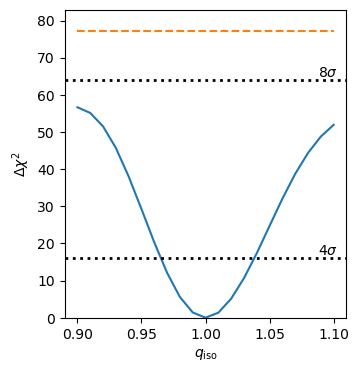

In [9]:
plotting.plot_profile_comparison(profiles, profiles_nowiggle, cl=[4, 8])

## Convergence of broadband parameters
Let us study the convergence of the error on $q_{\mathrm{iso}}$ with the period of broadband kernels: the error remain stable as long as this period is larger than the BAO scale.

In [10]:
rs_drag = template.fiducial.rs_drag
fracs = np.linspace(0.5, 2., 15)
intervals = []

for frac in fracs:
    theory.init.update(kp=frac * 2. * np.pi / rs_drag)
    for param in likelihood.all_params.select(basename=['al*', 'ml*']): param.update(derived='.auto')
    profiler = MinuitProfiler(likelihood, seed=42)
    profiler.maximize(niterations=2)
    intervals.append(profiler.interval('qiso').interval['qiso'])

[000056.96] [0/1] 05-24 06:02  MinuitProfiler            INFO     Varied parameters: ['qiso'].
[000057.10] [0/1] 05-24 06:02  Differentiation           INFO     Varied parameters: ['al0_0', 'al0_1', 'al0_2', 'al0_3', 'al0_4', 'al0_5', 'al0_6', 'al0_7', 'al0_8', 'al0_9', 'al0_10', 'al0_11', 'al2_0', 'al2_1', 'al2_2', 'al2_3', 'al2_4', 'al2_5', 'al2_6', 'al2_7', 'al2_8', 'al2_9', 'al2_10', 'al2_11', 'ml0_0', 'ml0_1', 'ml0_2', 'ml0_3', 'ml0_4', 'ml0_5', 'ml0_6', 'ml0_7', 'ml0_8', 'ml0_9', 'ml0_10', 'ml0_11', 'ml2_0', 'ml2_1', 'ml2_2', 'ml2_3', 'ml2_4', 'ml2_5', 'ml2_6', 'ml2_7', 'ml2_8', 'ml2_9', 'ml2_10', 'ml2_11'].
[000057.14] [0/1] 05-24 06:02  Differentiation           INFO     Varied parameters: ['al0_0', 'al0_1', 'al0_2', 'al0_3', 'al0_4', 'al0_5', 'al0_6', 'al0_7', 'al0_8', 'al0_9', 'al0_10', 'al0_11', 'al2_0', 'al2_1', 'al2_2', 'al2_3', 'al2_4', 'al2_5', 'al2_6', 'al2_7', 'al2_8', 'al2_9', 'al2_10', 'al2_11', 'ml0_0', 'ml0_1', 'ml0_2', 'ml0_3', 'ml0_4', 'ml0_5', 'ml0_6', 'ml0_7', 

[000287.24] [0/1] 05-24 06:06  Differentiation           INFO     Varied parameters: ['al0_0', 'al0_1', 'al0_2', 'al0_3', 'al0_4', 'al2_0', 'al2_1', 'al2_2', 'al2_3', 'al2_4', 'ml0_0', 'ml0_1', 'ml0_2', 'ml0_3', 'ml0_4', 'ml2_0', 'ml2_1', 'ml2_2', 'ml2_3', 'ml2_4'].
[000287.26] [0/1] 05-24 06:06  Differentiation           INFO     Varied parameters: ['al0_0', 'al0_1', 'al0_2', 'al0_3', 'al0_4', 'al2_0', 'al2_1', 'al2_2', 'al2_3', 'al2_4', 'ml0_0', 'ml0_1', 'ml0_2', 'ml0_3', 'ml0_4', 'ml2_0', 'ml2_1', 'ml2_2', 'ml2_3', 'ml2_4'].
[000299.37] [0/1] 05-24 06:06  MinuitProfiler            INFO     Varied parameters: ['qiso'].
[000299.41] [0/1] 05-24 06:06  Differentiation           INFO     Varied parameters: ['al0_0', 'al0_1', 'al0_2', 'al0_3', 'al0_4', 'al2_0', 'al2_1', 'al2_2', 'al2_3', 'al2_4', 'ml0_0', 'ml0_1', 'ml0_2', 'ml0_3', 'ml0_4', 'ml2_0', 'ml2_1', 'ml2_2', 'ml2_3', 'ml2_4'].
[000299.43] [0/1] 05-24 06:06  Differentiation           INFO     Varied parameters: ['al0_0', 'al0_1', 

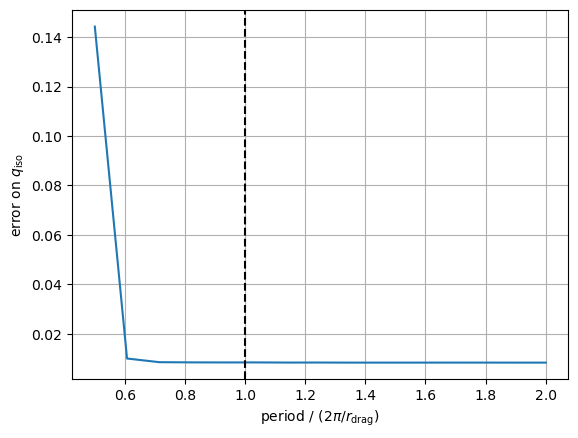

In [11]:
ax = plt.gca()
ax.plot(fracs, np.diff(intervals, axis=-1) / 2)
ax.set_xlabel(r'period / $(2 \pi / r_{\mathrm{drag}})$')
ax.set_ylabel(r'error on $q_{\mathrm{iso}}$')
ax.grid(True)
ax.axvline(x=1., color='k', linestyle='--')
plt.show()

## Correlation function
For the correlation function, *desilike* simply takes the Hankel transform of the above power spectrum theory multipoles.

In [12]:
z = 1.
template = BAOPowerSpectrumTemplate(z=z, fiducial='DESI', apmode='qiso')
theory = FlexibleBAOWigglesTracerCorrelationFunctionMultipoles(template=template)
params = {'b1': 2.}
# Generate synthetic monopole and quadrupole, between 0.02 and 0.2 h/Mpc
observable = TracerCorrelationFunctionMultipolesObservable(data=params, covariance=None,
                                                           slim={0: [30., 150., 2.], 2: [30., 150., 2.]},
                                                           theory=theory)

observable.init.update(data=observable.flatdata)  # fix the data vector

from desilike.observables.galaxy_clustering import BoxFootprint, ObservablesCovarianceMatrix

footprint = BoxFootprint(volume=5e9, nbar=1e-4)  # box with volume of 5 (Gpc/h)^3 and density of 1e-4 (h/Mpc)^3
covariance = ObservablesCovarianceMatrix(observables=[observable], footprints=[footprint])
likelihood = ObservablesGaussianLikelihood(observables=[observable], covariance=covariance(**params))

/home/adematti/anaconda3/envs/cosmodesi/lib/python3.9/site-packages/numpy/lib/polynomial.py:1337: FutureWarning: In the future extra properties will not be copied across when constructing one poly1d from another
  other = poly1d(other)


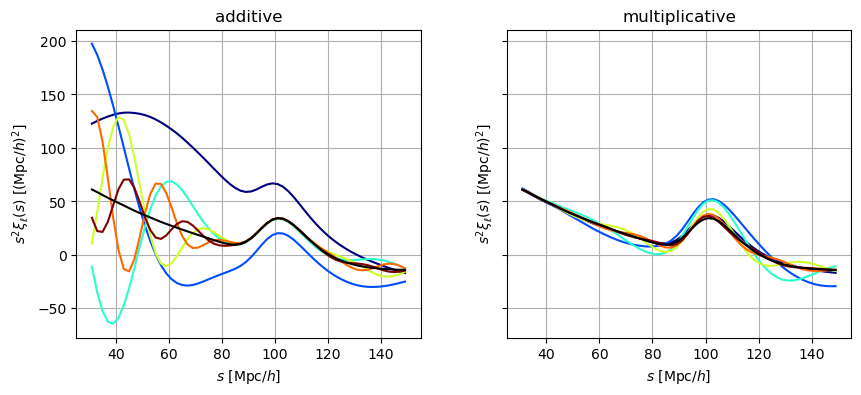

In [13]:
fig, lax = plt.subplots(1, 2, sharex=False, sharey=True, figsize=(10, 4), squeeze=True)
fig.subplots_adjust(wspace=0.25)

for iax, mode in enumerate(['additive', 'multiplicative']):
    ax = lax[iax]
    names = theory.all_params.names(basename=mode[0] + 'l0*')
    cmap = plt.get_cmap('jet', len(names))
    for iname, name in enumerate(names):
        xi = theory(**{name: 2. if iax == 0 else 2.})
        for ill, ell in enumerate(theory.ells[:1]):
            ax.plot(theory.s, theory.s**2 * xi[ill], color=cmap(iname * 1. / len(names)))
        xi = theory(**{name: 0.})
    ax.plot(theory.s, theory.s**2 * xi[ill], color='k')
    ax.grid(True)
    ax.set_xlabel(r'$s$ [$\mathrm{Mpc}/h$]')
    ax.set_ylabel(r'$s^{2} \xi_{\ell}(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
    ax.set_title(mode)
plt.show()

In [14]:
rs_drag = template.fiducial.rs_drag
fracs_xi = np.linspace(0.7, 2., 15)
intervals_xi = []

for frac in fracs_xi:
    theory.init.update(kp=frac * 2. * np.pi / rs_drag)
    for param in likelihood.all_params.select(basename=['al*', 'ml*']): param.update(derived='.auto')
    profiler = MinuitProfiler(likelihood, seed=42)
    profiler.maximize(niterations=2)
    intervals_xi.append(profiler.interval('qiso').interval['qiso'])

[000354.61] [0/1] 05-24 06:07  MinuitProfiler            INFO     Varied parameters: ['qiso'].
[000354.81] [0/1] 05-24 06:07  Differentiation           INFO     Varied parameters: ['al0_0', 'al0_1', 'al0_2', 'al0_3', 'al0_4', 'al0_5', 'al0_6', 'al0_7', 'al2_0', 'al2_1', 'al2_2', 'al2_3', 'al2_4', 'al2_5', 'al2_6', 'al2_7', 'ml0_0', 'ml0_1', 'ml0_2', 'ml0_3', 'ml0_4', 'ml0_5', 'ml0_6', 'ml0_7', 'ml2_0', 'ml2_1', 'ml2_2', 'ml2_3', 'ml2_4', 'ml2_5', 'ml2_6', 'ml2_7'].
[000354.85] [0/1] 05-24 06:07  Differentiation           INFO     Varied parameters: ['al0_0', 'al0_1', 'al0_2', 'al0_3', 'al0_4', 'al0_5', 'al0_6', 'al0_7', 'al2_0', 'al2_1', 'al2_2', 'al2_3', 'al2_4', 'al2_5', 'al2_6', 'al2_7', 'ml0_0', 'ml0_1', 'ml0_2', 'ml0_3', 'ml0_4', 'ml0_5', 'ml0_6', 'ml0_7', 'ml2_0', 'ml2_1', 'ml2_2', 'ml2_3', 'ml2_4', 'ml2_5', 'ml2_6', 'ml2_7'].
[000389.38] [0/1] 05-24 06:08  MinuitProfiler            INFO     Varied parameters: ['qiso'].
[000389.53] [0/1] 05-24 06:08  Differentiation           INF

[000613.64] [0/1] 05-24 06:11  Differentiation           INFO     Varied parameters: ['al0_0', 'al0_1', 'al0_2', 'al0_3', 'al2_0', 'al2_1', 'al2_2', 'al2_3', 'ml0_0', 'ml0_1', 'ml0_2', 'ml0_3', 'ml2_0', 'ml2_1', 'ml2_2', 'ml2_3'].
[000613.66] [0/1] 05-24 06:11  Differentiation           INFO     Varied parameters: ['al0_0', 'al0_1', 'al0_2', 'al0_3', 'al2_0', 'al2_1', 'al2_2', 'al2_3', 'ml0_0', 'ml0_1', 'ml0_2', 'ml0_3', 'ml2_0', 'ml2_1', 'ml2_2', 'ml2_3'].
[000629.12] [0/1] 05-24 06:12  MinuitProfiler            INFO     Varied parameters: ['qiso'].
[000629.17] [0/1] 05-24 06:12  Differentiation           INFO     Varied parameters: ['al0_0', 'al0_1', 'al0_2', 'al0_3', 'al2_0', 'al2_1', 'al2_2', 'al2_3', 'ml0_0', 'ml0_1', 'ml0_2', 'ml0_3', 'ml2_0', 'ml2_1', 'ml2_2', 'ml2_3'].
[000629.18] [0/1] 05-24 06:12  Differentiation           INFO     Varied parameters: ['al0_0', 'al0_1', 'al0_2', 'al0_3', 'al2_0', 'al2_1', 'al2_2', 'al2_3', 'ml0_0', 'ml0_1', 'ml0_2', 'ml0_3', 'ml2_0', 'ml2_1', 

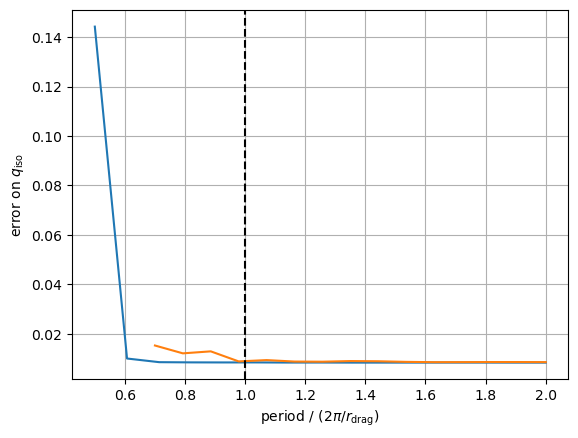

In [15]:
ax = plt.gca()
ax.plot(fracs, np.diff(intervals, axis=-1) / 2, label=r'$P(k)$')
ax.plot(fracs_xi, np.diff(intervals_xi, axis=-1) / 2, label=r'$\xi(s)$')
ax.set_xlabel(r'period / $(2 \pi / r_{\mathrm{drag}})$')
ax.set_ylabel(r'error on $q_{\mathrm{iso}}$')
ax.grid(True)
ax.axvline(x=1., color='k', linestyle='--')
plt.show()